In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


In [ ]:
import numpy as np
import pandas as pd
import datetime
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import utils.time_series_processing as tsp
import utils.visualisation as vs

In [ ]:
print(tf.__version__)

2.19.0


## Prepare dataset

In [ ]:
TICKER = "INDF"
SEQ_LEN = 60
PRED_HORIZON = 22
VAL_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,6016.364746,6016.364746,5930.722543,5994.954195,2961000,0.131148
2022-07-12,6037.774414,6080.595509,5973.542771,6037.774414,5209400,0.205047
2022-07-13,5845.080078,5994.953926,5823.669528,5994.953926,10978800,0.204082
2022-07-14,5930.722168,5952.132717,5823.669421,5845.079971,7611600,0.259887
2022-07-15,5909.312500,5952.133605,5845.080842,5930.723053,4235000,0.334204
...,...,...,...,...,...,...
2025-07-25,8400.000000,8400.000000,8300.000000,8350.000000,3388300,-0.212928
2025-07-28,8375.000000,8475.000000,8350.000000,8475.000000,3305800,-0.064327
2025-07-29,8300.000000,8400.000000,8275.000000,8350.000000,3728500,-0.176030


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-07-11 to 2025-07-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           732 non-null    float64
 1   High            732 non-null    float64
 2   Low             732 non-null    float64
 3   Open            732 non-null    float64
 4   Volume          732 non-null    int64  
 5   nilai_sentimen  732 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 40.0 KB


In [ ]:
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,6016.364746,6016.364746,5930.722543,5994.954195,2961000,0.131148
2022-07-12,6037.774414,6080.595509,5973.542771,6037.774414,5209400,0.205047
2022-07-13,5845.080078,5994.953926,5823.669528,5994.953926,10978800,0.204082
2022-07-14,5930.722168,5952.132717,5823.669421,5845.079971,7611600,0.259887
2022-07-15,5909.312500,5952.133605,5845.080842,5930.723053,4235000,0.334204
...,...,...,...,...,...,...
2025-07-25,8400.000000,8400.000000,8300.000000,8350.000000,3388300,-0.212928
2025-07-28,8375.000000,8475.000000,8350.000000,8475.000000,3305800,-0.064327
2025-07-29,8300.000000,8400.000000,8275.000000,8350.000000,3728500,-0.176030


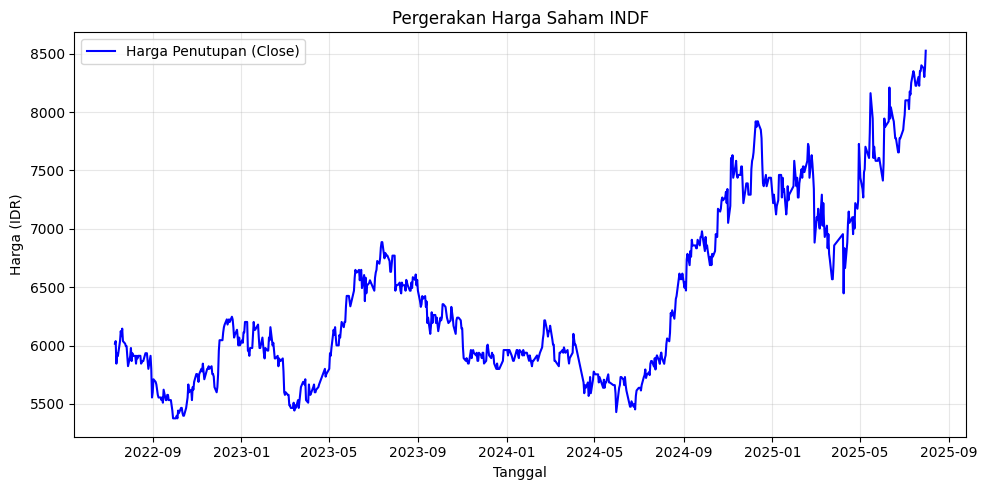

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,6016.364746,2961000,0.131148
2022-07-12,6037.774414,5209400,0.205047
2022-07-13,5845.080078,10978800,0.204082
2022-07-14,5930.722168,7611600,0.259887
2022-07-15,5909.312500,4235000,0.334204
...,...,...,...
2025-07-25,8400.000000,3388300,-0.212928
2025-07-28,8375.000000,3305800,-0.064327
2025-07-29,8300.000000,3728500,-0.176030


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
print("Train samples:", X_train.shape[0], "val samples:", X_val.shape[0])

Train samples: 520 val samples: 131


In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

## Ensemble

In [ ]:
lstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_lstm_model.keras")
bilstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_bilstm_model.keras")
gru_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_gru_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model_names = ["LSTM", "BiLSTM", "GRU"]
models = [lstm_model, bilstm_model, gru_model]

In [ ]:
individual_predictions_train = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_train)
    individual_predictions_train[name] = pred

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [ ]:
print(individual_predictions_train.keys())

dict_keys(['LSTM', 'BiLSTM', 'GRU'])


In [ ]:
print(individual_predictions_train)

{'LSTM': array([[0.03580954, 0.0435183 , 0.03655225, ..., 0.08570324, 0.0808394 ,
        0.08930541],
       [0.03424232, 0.04223438, 0.03474405, ..., 0.09281534, 0.08849074,
        0.09628054],
       [0.03371779, 0.04149583, 0.03385746, ..., 0.09968223, 0.09649461,
        0.10372115],
       ...,
       [0.5612846 , 0.56925595, 0.5807794 , ..., 0.5763901 , 0.5727571 ,
        0.56616443],
       [0.5702998 , 0.5768393 , 0.5860605 , ..., 0.5594595 , 0.55666167,
        0.548533  ],
       [0.57822007, 0.5834248 , 0.5903819 , ..., 0.54778636, 0.5459481 ,
        0.5371742 ]], dtype=float32), 'BiLSTM': array([[0.06775886, 0.06106923, 0.04829884, ..., 0.14908886, 0.13637033,
        0.14038712],
       [0.06126909, 0.05654539, 0.04219045, ..., 0.15877217, 0.14025034,
        0.14548326],
       [0.05607796, 0.05150908, 0.03622244, ..., 0.16794686, 0.14445835,
        0.15115759],
       ...,
       [0.61571693, 0.63096076, 0.646995  , ..., 0.6971115 , 0.71463513,
        0.70822686],


In [ ]:
individual_predictions_val = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    individual_predictions_val[name] = pred

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
print(individual_predictions_val.keys())

dict_keys(['LSTM', 'BiLSTM', 'GRU'])


In [ ]:
train_preds = list(individual_predictions_train.values())
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=2)
X_stack_train = X_stack_train.reshape(X_stack_train.shape[0], -1)
X_stack_val = np.stack(val_preds, axis=2)
X_stack_val = X_stack_val.reshape(X_stack_val.shape[0], -1)

In [ ]:
print(train_preds[1])

[[0.06775886 0.06106923 0.04829884 ... 0.14908886 0.13637033 0.14038712]
 [0.06126909 0.05654539 0.04219045 ... 0.15877217 0.14025034 0.14548326]
 [0.05607796 0.05150908 0.03622244 ... 0.16794686 0.14445835 0.15115759]
 ...
 [0.61571693 0.63096076 0.646995   ... 0.6971115  0.71463513 0.70822686]
 [0.6289125  0.6439105  0.6605948  ... 0.68503255 0.70415103 0.69702476]
 [0.6517216  0.66697043 0.6842583  ... 0.6650121  0.68430424 0.6755758 ]]


In [ ]:
meta_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(22, activation='linear', input_shape=(66,))
])

meta_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping based on validation loss
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = meta_model.fit(
    X_stack_train, y_train,
    validation_data=(X_stack_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1820 - mae: 0.2879 - val_loss: 0.2945 - val_mae: 0.3621
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0495 - mae: 0.1219 - val_loss: 0.0759 - val_mae: 0.1634
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - mae: 0.0668 - val_loss: 0.0210 - val_mae: 0.0921
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - mae: 0.0472 - val_loss: 0.0093 - val_mae: 0.0727
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - mae: 0.0403 - val_loss: 0.0070 - val_mae: 0.0661
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mae: 0.0386 - val_loss: 0.0067 - val_mae: 0.0646
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mae: 0.0380 - val_loss: 0.0066 - val_mae: 0.0638
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mae: 0.0376 - val_loss: 0.0064 - val_mae: 0.0630
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mae: 0.

In [ ]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
future_predictions_base = tsp.predict_ensemble(
    models, scaler, last_seq, meta_model)

print(future_predictions_base[0])

[8549.38247187 7876.58215736 7968.42909432 7972.24106057 8094.92133041
 8025.79005667 7439.09649186 7729.375667   7775.2365504  7789.87789372
 7899.81144986 8527.47675531 7719.26878637 8497.06153204 7823.8528663
 7741.46462747 7922.64909299 7474.54779677 7889.43696405 7984.54264141
 8430.34358405 7461.92343829]


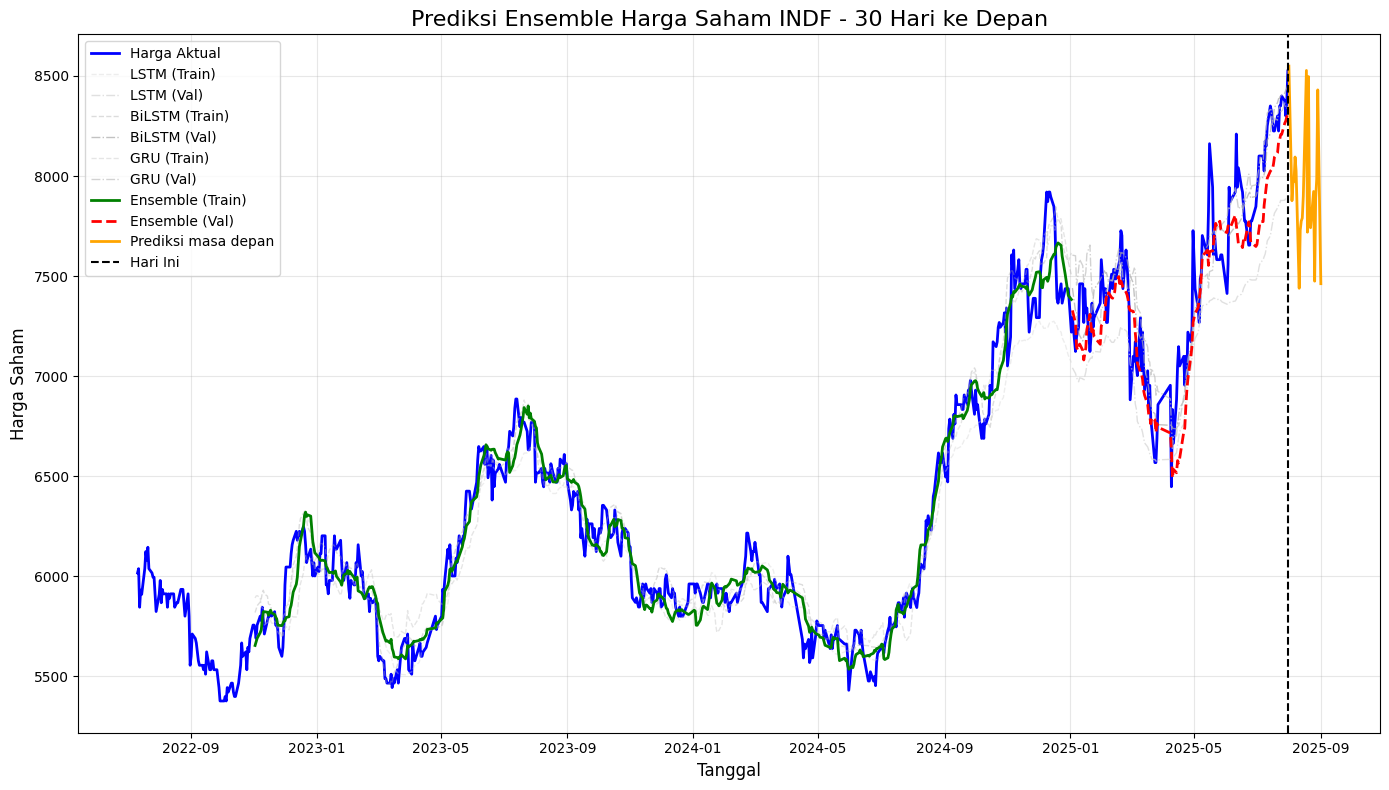

In [ ]:
vs.plot_ensemble_predictions(
    df, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base[0], TICKER
)

In [ ]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base[0].flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-08-01,8549.382472
2025-08-04,7876.582157
2025-08-05,7968.429094
2025-08-06,7972.241061
2025-08-07,8094.921330
2025-08-08,8025.790057
2025-08-11,7439.096492
2025-08-12,7729.375667
2025-08-13,7775.236550


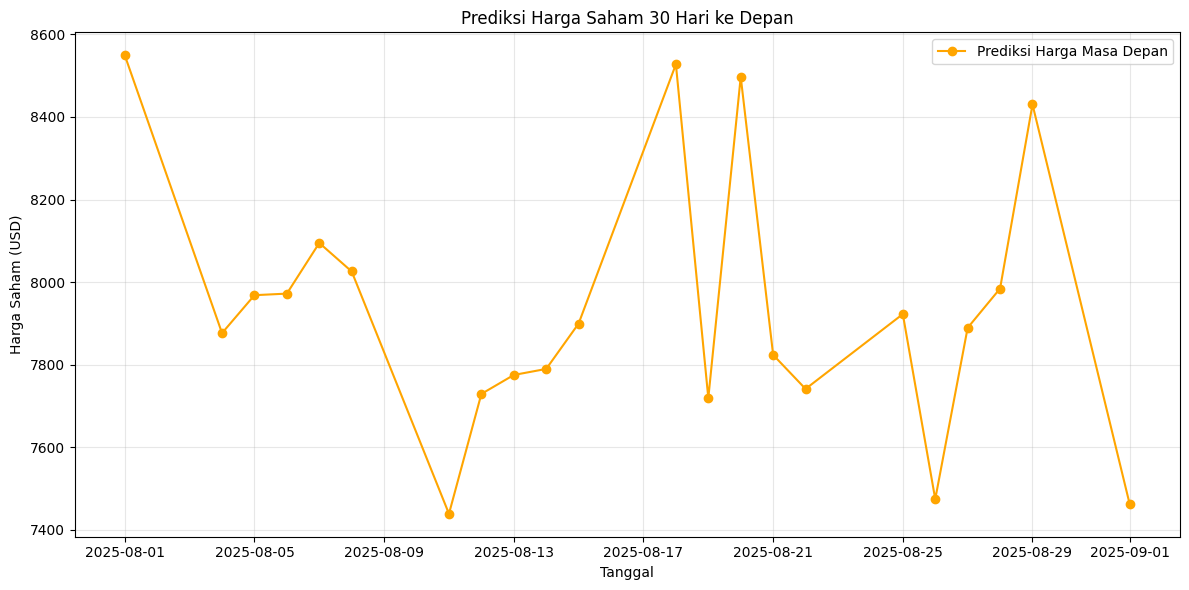

In [ ]:
vs.plot_future_predictions(future_dates, future_predictions_base[0])

In [ ]:
print(f"Evaluasi hasil prediksi pada Data Validasi:")
tsp.model_evaluate(y_val, ensemble_preds_hist_val)

Evaluasi hasil prediksi pada Data Validasi:
MAE  : 0.0437
MAPE : 6.8036%
MSE  : 0.0031
RMSE : 0.0559
R2   : 0.8119


In [ ]:
y_val_inv = inverse_scaler(y_val)
ensemble_preds_hist_val_inv = inverse_scaler(ensemble_preds_hist_val)

print(f"Evaluasi hasil prediksi pada Data Validasi:")
tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

Evaluasi hasil prediksi pada Data Validasi:
MAE  : 137.4324
MAPE : 1.8385%
MSE  : 30946.0236
RMSE : 175.9148
R2   : 0.8194


In [ ]:
meta_model.save(f"./model/{TICKER}/meta_model.keras")
meta_model.save(f"./model/{TICKER}/meta_model.h5")